# Local Area Unemployment and Employment Statistics


In [1]:
# Hide warnings
import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append('../src')

import requests

import uschartbook.config

from uschartbook.config import *
from uschartbook.utils import *

# Import libraries and adjust settings
%matplotlib inline

import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Polygon
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.patches import Rectangle
from matplotlib.colors import Normalize, LinearSegmentedColormap
plt.rc('font', family='Lato')

# CSV file contains city names, their BLS codes (Metropolitan 
# MTAs/NECTAs only), and their latitude and longitude
MSA = pd.read_csv('shapefiles/MSA.csv')

### MSA-level unemployment change

In [2]:
# BLS flat file contains the unemployment rate by month since 2015
url = 'https://download.bls.gov/pub/time.series/la/la.data.60.Metro'
df = pd.read_table(url, sep='\s+', dtype='object')
date = lambda x: x['year'].astype('str') + '-' + x['period'].str[1:] + '-01'

data = (df[df['series_id'].isin(MSA['fullcode']) & ~df['period'].isin(['M13'])]
          .assign(DATE = date)
          .set_index(['series_id','DATE'])
          .value).unstack().T.dropna().astype('float')
data.to_csv(data_dir / 'msa_unemp_raw.csv', index_label='date')

lfs = [f'{c[:-1]}6' for c in MSA.fullcode]
data2 = (df.query('series_id in @lfs and period != "M13"')
         .assign(DATE = date).set_index(['series_id','DATE'])
         .value).unstack().T.dropna().astype('float')
data2.to_csv(data_dir / 'msa_lf_raw.csv', index_label='date')

print('Latest:', dtxt(data.index[-1])['mon1'])

Latest: January 2022


In [3]:
data = pd.read_csv(data_dir / 'msa_unemp_raw.csv', 
                   index_col='date', parse_dates=True)
ltdt = dtxt(data.index[-1])['mon1']
pr = -37 if data.index[-1] >= pd.to_datetime('2022-03-01') else -25
prtxt = 'three' if pr == -37 else 'two'
lt = data.iloc[-1].rename('latest')
pc = data.iloc[pr].rename('precov')
ch = (data.iloc[-1] - data.iloc[pr]).rename('value')
prdt = dtxt(data.index[pr])['mon1']
write_txt(text_dir / 'unemp_map_date.txt', ' to '.join([prdt, ltdt]))
ms = MSA.set_index('fullcode').join(ch).join(lt).join(pc)
ms['color'] = np.where(ms.value > 0.2, 'blue', 
                       np.where(ms.value < -0.2, 'greenyellow', 'gray'))
ms['size'] = np.where(abs(ms.value) > 0.2, (abs(ms.value*4)), 2)

In [4]:
# Labor force size and change
lf = pd.read_csv(data_dir / 'msa_lf_raw.csv', 
                   index_col='date', parse_dates=True)

lfc = [f'{c[:-1]}3' for c in lf.columns]
lf.columns = lfc
lfl = MSA.set_index('fullcode').join(lf.iloc[-1].rename('labor_force'))
lft = lfl.sort_values('labor_force', ascending=False)['labor_force']
lfch = (lf.pct_change(abs(pr)).iloc[-1] * 100).rename('LFCH').round(1)

cols = data.index[[-37, -25, -13, -4, -3, -2, -1]]
colnames = [dtxt(i)['mon2'] for i in cols]
r = data.loc[data.index[[-37, -25, -13, -4, -3, -2, -1]]].T
r.columns = colnames
pc = ((data.iloc[-1] - data.loc['2019'].mean())
      .rename('Change since 2019'))
m3lt = ((data.iloc[-3:].mean() - data.iloc[-6:-3].mean())
        .rename(dtxt(data.index[-1])['mon2'] + ' 3M'))
m3pr = ((data.iloc[-4:-1].mean() - data.iloc[-7:-4].mean())
        .rename(dtxt(data.index[-2])['mon2'] + ' 3M'))
m12 = data.diff(12).iloc[-2:].T
m12.columns = [f'{i} 12M' for i in colnames[-2:]]
if 'Apr 2020' not in colnames:
    cov = data.loc['2020-04-01'].rename('Apr 2020')
    r = r.join(cov)
r = r.join(m3pr).join(m3lt).join(m12).join(pc).round(1).join(lft).join(lfch)
final = MSA.set_index('fullcode')[['fullname', 'area_code']].join(r)
final.to_csv(data_dir / 'msa_unemp_rate.csv', index_label='BLSID')

incn = len(ch[ch > 0.2])
decn = len(ch[ch < -0.2])
samen = len(ch[(ch <= 0.2) & (ch >= -0.2)])
text = (f'From {prdt} to {ltdt}, unemployment rates fell by 0.3 '+
        f'percentage point or more in {decn} metro areas, and '+
        f'increased by 0.3 percentage point or more in {incn} metro '+
        'areas. Recent local unemployment rates were within 0.2 '+
        'percentage points of their pre-pandemic level in '+
        f'{samen} metro areas. ')
write_txt(text_dir / 'msa_unemp_ch_n.txt', text)
print(text)
ms10 = (ms.join(lft).join(lfch).dropna()
          .sort_values('labor_force', ascending=False).iloc[:11])

From January 2020 to January 2022, unemployment rates fell by 0.3 percentage point or more in 147 metro areas, and increased by 0.3 percentage point or more in 172 metro areas. Recent local unemployment rates were within 0.2 percentage points of their pre-pandemic level in 68 metro areas. 


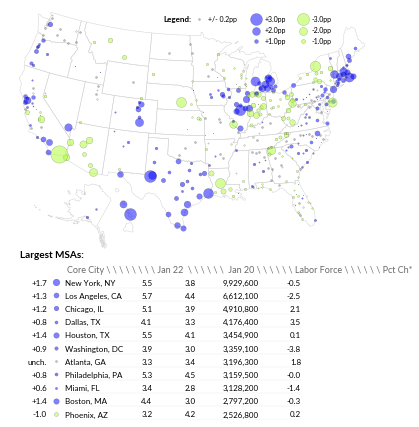

In [5]:
# Map and legend settings
fig, (ax, ax2) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [5, 2.5]}, 
                              figsize=(6.5,8.0))
m = Basemap(llcrnrlon=-119, llcrnrlat=20, urcrnrlon=-64, urcrnrlat=49,
            projection='lcc', lat_1=33, lat_2=45, lon_0=-95)
m.readshapefile('shapefiles/states', 'st', drawbounds=True, color='lightgrey', ax=ax)
   
for info, shape in zip(m.st_info, m.st):
    if info['STATE_NAME'] == 'Hawaii':
        shape2 = [[x + 5200000, y - 1400000] for x, y in shape]
        ax.add_patch(Polygon(shape2, fc='white', ec='lightgray', lw=0.5)) 
    elif info['STATE_NAME'] == 'Alaska':
        shape2 = [(x * 0.34 + 1200000, 
                  y * 0.34 - 1300000) for x, y in shape]
        ax.add_patch(Polygon(shape2, fc='white', ec='lightgray', lw=0.5))    
        
# Plot each location, value, and color as identified in the previous section        
for index, row in ms.iterrows():
    x, y = m(row['longitude'], row['latitude'])
    if row['fullname'].endswith('HI'):
        x = x + 5200000
        y = y - 1400000
    if row['fullname'].endswith('AK'):
        x = x * 0.34 + 1200000
        y = y * 0.34 - 1300000
    ax.plot(x, y, marker='o', color=row['color'], alpha=0.5, markersize=row['size'], 
           markeredgecolor='black', markeredgewidth=.25)

plt.annotate('Legend:', xy=(0.43, 0.94), xycoords=ax, fontsize=8, 
             fontweight='bold')
legs = [(0.53, 0.95, 'gray', 2, '+/- 0.2pp'), (0.685, 0.95, 'blue', 12, '+3.0pp'), 
        (0.685, 0.905, 'blue', 8, '+2.0pp'), (0.685, 0.86, 'blue', 4, '+1.0pp'),
        (0.815, 0.95, 'greenyellow', 12, '-3.0pp'), 
        (0.815, 0.905, 'greenyellow', 8, '-2.0pp'), 
        (0.815, 0.86, 'greenyellow', 4, '-1.0pp')]

for x, y, color, size, text in legs:
    y2 = y - 0.005 if y == 0.905 else y
    ax.plot(x, y2, marker='o', color=color, alpha=0.5, markersize=size, 
            markeredgecolor='black', markeredgewidth=.25, transform=ax.transAxes) 
    ax.annotate(text, xy=(x + 0.025, y * 0.99), xycoords=ax, fontsize=7)
ax.axis('off')

for i, row in ms10.reset_index().iterrows():
    ax2.plot(0.135, 0.95 - (i / 11), marker='o', color=row['color'], 
             alpha=0.5, markersize=row['size'], markeredgecolor='black', 
             markeredgewidth=.25, transform=ax2.transAxes) 
    #val = f'{row["value"]:.1f}pp' if round(abs(row['value']), 1) > 0 else 'unch.'
    ax2.annotate(row['fullname'], xy=(0.16, 0.93 - (i / 11)), xycoords=ax2, fontsize=8)
    ax2.annotate(row['latest'], xy=(0.37, 0.93 - (i / 11)), xycoords=ax2, fontsize=8)
    ax2.annotate(row['precov'], xy=(0.49, 0.93 - (i / 11)), xycoords=ax2, fontsize=8)
    pos = '+' if row['value'] > 0 else ''
    val = f'{pos}{row["value"]:.1f}' if round(abs(row['value']), 1) > 0.2 else 'unch.'
    ax2.annotate(val, xy=(0.11, 0.93 - (i / 11)), xycoords=ax2, fontsize=8, ha='right')
    lfv = f"{round(row['labor_force'], -2):,.0f}"
    ax2.annotate(lfv, xy=(0.595, 0.93 - (i / 11)), xycoords=ax2, fontsize=8)
    lfch = f"{row['LFCH']:.1f}"
    ax2.annotate(lfch, xy=(0.81, 0.93 - (i / 11)), xycoords=ax2, fontsize=8, ha='right')
    ax2.plot([0.16, 0.81], [0.91 - (i / 11)]*2, transform=ax2.transAxes, linewidth=0.25, 
               color='gainsboro')

    
ax2.axis('off')
plt.subplots_adjust(wspace=0, hspace=0)
plt.text(-0.051, 0.068, 'Largest MSAs:', weight='bold')
mo1, mo2 = dtxt(lf.index[-1])['mon7'], dtxt(lf.index[pr])['mon7']
header = (f'Core City \ \ \ \ \ \ \ \ {mo1}  '+
          f'\ \ \ \ \ \  {mo2} \ \ \ \ \ \ Labor'+
          ' Force \ \ \ \ \ \ Pct Ch*')
plt.text(-0.037, 0.057, header, fontsize=9, color='dimgray')

plt.savefig(data_dir / 'unemp_msa.pgf', bbox_inches='tight')

### State data

In [2]:
laus_raw_url = 'https://www.bls.gov/web/laus/ststdnsadata.txt'
r = requests.get(laus_raw_url)
raw_data = [line for line in r.text.split('\n')[16:] 
            if line[:2] != '\r']

epop, unrate = {}, {}

for row in raw_data:
    if row[:5] == '     ':
        date_text = row.strip().replace('\r', '')
        date = pd.to_datetime(date_text)
        epop[date], unrate[date] = {}, {}
    if len(row) > 0:
        if row[0] != ' ':
            state = row.split('.')[0].strip()
            unrate_val = float(row.split()[-1])
            unrate[date][state] = unrate_val
            epop_val = float(row.split()[-3])
            epop[date][state] = epop_val

df1 = pd.DataFrame(epop).T
df1.to_csv(data_dir / 'state_epop.csv', index_label='date')
df2 = pd.DataFrame(unrate).T
df2.to_csv(data_dir / 'state_unrate.csv', index_label='date')

### State-level unemployment

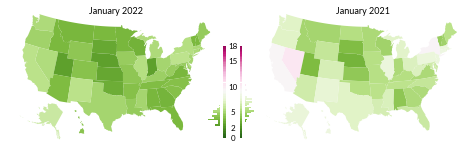

In [3]:
data = pd.read_csv(data_dir / 'state_unrate.csv', 
                   index_col='date', parse_dates=True)

# Map settings
m = Basemap(llcrnrlon=-121, llcrnrlat=20, urcrnrlon=-64, urcrnrlat=49,
            projection='lcc', lat_1=33, lat_2=45, lon_0=-95)
m.readshapefile('shapefiles/states', 'states', drawbounds=False);

states = list(set([i['STATE_NAME'] for i in m.states_info]))
vmin=0
vmax=18
cmap = plt.cm.PiYG_r
norm = Normalize(vmin=vmin, vmax=vmax)

# Draw map
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(7.0, 2.4))
fig.tight_layout()

for group, axval in [(-1, 0), (-13, 1)]:
    plt.sca(axes[axval])
    axes[axval].axis('off')
    m.drawmapboundary()
    
    for info, shape in zip(m.states_info, m.states):
        
        fc = cmap(norm(data[info['STATE_NAME']].iloc[group]))
        # Alaska and Hawaii moved
        if info['STATE_NAME'] == 'Hawaii':
            shape = [(x + 5200000, y - 1400000) for x,y in shape]
        elif info['STATE_NAME'] == 'Alaska':
            shape = [(x*0.35 + 1100000, y*0.35 - 1300000) for x,y in shape]
        axes[axval].add_patch(Polygon(shape, fc=fc))
    
    date = dtxt(data.index[group])['mon1']
    plt.text(0.4, 0.98, date, fontsize=9, 
             transform=axes[axval].transAxes)
    
ax_inset = inset_axes(axes[0], width='-30%', height='70%', loc=4, borderpad=0.5)
for tick_label in [0, 2, 5, 10, 15, 18]:
    plt.text(0.6, norm(tick_label), tick_label, fontsize=8, 
             ha='center', va='center', transform=ax_inset.transAxes)
ax_inset.axis('off')

# Draw custom legend
for group, pt, pt2 in [(-1, 0.71, 0.8), (-13, 0.44, 0.4)]:
    for i in np.linspace(0,18,56):
        rect = Rectangle(xy=(pt, norm(i)), width=0.04, height=1/56, 
                         fc=cmap(norm(i)), ec=None)
        ax_inset.add_patch(rect)    
    
    bins = pd.cut(data.iloc[group], np.linspace(0,18,54)).apply(lambda x: x.left)
    res = data.iloc[group].groupby(bins).count()
    for i, v in res.items():
        if group == -1:
            adj = (v / 50)
        else:
            adj = 0
        if v > 0:
            rect = Rectangle(xy=(pt2 + adj, norm(i)), width= -(v / 50), 
                             height=1/54, fc=cmap(norm(i)), ec=None)
            ax_inset.add_patch(rect)    
    
plt.savefig('../chartbook/data/unemp_map.pgf', bbox_inches='tight')

In [4]:
numbers2 = {0: 'no', 1: 'one', 2: 'two', 3: 'three', 4: 'four', 5: 'five', 
           6: 'six', 7: 'seven', 8: 'eight', 9: 'nine'}

ltmonth = dtxt(data.index[-1])['mon1']
prmonth = dtxt(data.index[-13])['mon1']
d1 = data.iloc[-1].sort_values()
dap = data.loc['2020-04-01'].sort_values()
dpr = data.iloc[-13].sort_values()
a10 = len(d1[d1 > 8])
if a10 < 10:
    a10 = numbers2[a10]
a10pr = len(dpr[dpr > 8])
if a10pr < 10:
    a10pr = numbers2[a10pr]
a10ap = len(dap[dap > 8])
if a10ap < 10:
    a10ap = numbers2[a10ap] 
    
a5pr = len(dpr[dpr > 5])
if a5pr < 10:
    a5pr = numbers2[a5pr]
    
a5 = len(d1[d1 > 5])
if a5 < 10:
    a5 = numbers2[a5]
    
h, l = {}, {}
for i in [1, 2, 3]:
    h[i] = f'{d1.index[-i]} ({d1.iloc[-i]}\%)'
    l[i] = f'{d1.index[i-1]} ({d1.iloc[i-1]}\%)'
    
text = (f'In {ltmonth}, {a10} states had an unemployment rate '+
        f'above eight percent, compared to {a10ap} states in April '+
        f'2020. One year prior, in {prmonth}, {a10pr} states had '+
        f'an unemployment rate above eight percent and {a5pr} states '+
        f'had an unemployment rate above five percent. In {ltmonth}, '+
        f'{a5} states have an unemployment rate above five percent.'+
        '\n\nThe states with the highest unemployment rates in '+
        f'{ltmonth} are {h[1]}, {h[2]}, and {h[3]}. The states with '+
        f'the lowest unemployment rates are {l[1]}, {l[2]}, and {l[3]}.')
write_txt(text_dir / 'state_unemp.txt', text)
print(text)   

In January 2022, no states had an unemployment rate above eight percent, compared to 49 states in April 2020. One year prior, in January 2021, three states had an unemployment rate above eight percent and 38 states had an unemployment rate above five percent. In January 2022, 11 states have an unemployment rate above five percent.

The states with the highest unemployment rates in January 2022 are District of Columbia (6.4\%), Alaska (6.1\%), and Pennsylvania (5.6\%). The states with the lowest unemployment rates are Nebraska (2.4\%), Indiana (2.4\%), and Utah (2.4\%).


### Employment rate by state

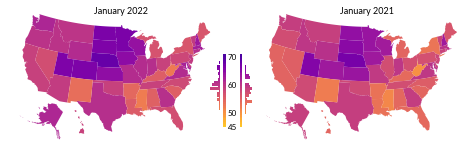

In [5]:
data = pd.read_csv(data_dir / 'state_epop.csv', 
                   index_col='date', parse_dates=True)

# Map settings
m = Basemap(llcrnrlon=-121, llcrnrlat=20, urcrnrlon=-64, urcrnrlat=49,
            projection='lcc', lat_1=33, lat_2=45, lon_0=-95)
m.readshapefile('shapefiles/states', 'states', drawbounds=False);

vmin=data.min().min()
vmax=data.max().max()
cmap = plt.cm.plasma_r
norm = Normalize(vmin=vmin, vmax=vmax)

# Draw map
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(7.0, 2.4))
fig.tight_layout()

for group, axval in [(-1, 0), (-13, 1)]:
    plt.sca(axes[axval])
    axes[axval].axis('off')
    m.drawmapboundary()
    
    for info, shape in zip(m.states_info, m.states):
        
        fc = cmap(norm(data[info['STATE_NAME']].iloc[group]))
        # Alaska and Hawaii moved
        if info['STATE_NAME'] == 'Hawaii':
            shape = [(x + 5200000, y - 1400000) for x,y in shape]
        elif info['STATE_NAME'] == 'Alaska':
            shape = [(x*0.35 + 1100000, y*0.35 - 1300000) for x,y in shape]
        axes[axval].add_patch(Polygon(shape, fc=fc))
    
    date = dtxt(data.index[group])['mon1']
    plt.text(0.42, 0.98, date, fontsize=9, 
             transform=axes[axval].transAxes)
    
ax_inset = inset_axes(axes[0], width='-30%', height='70%', loc=4, borderpad=0.5)
for tick_label in [45, 50, 60, 70]:
    plt.text(0.6, norm(tick_label), tick_label, fontsize=8, 
             ha='center', va='center', transform=ax_inset.transAxes)
ax_inset.axis('off')

# Draw custom legend
for group, pt, pt2 in [(-1, 0.71, 0.8), (-13, 0.44, 0.4)]:
    for i in np.linspace(45,70,40):
        rect = Rectangle(xy=(pt, norm(i)), width=0.04, height=1/35, 
                         fc=cmap(norm(i)), ec=None)
        ax_inset.add_patch(rect)    
    
    bins = pd.cut(data.iloc[group], np.linspace(45,70,33)).apply(lambda x: x.left)
    res = data.iloc[group].groupby(bins).count()
    for i, v in res.items():
        if group == -1:
            adj = (v / 50)
        else:
            adj = 0
        if v > 0:
            rect = Rectangle(xy=(pt2 + adj, norm(i)), width= -(v / 50), 
                             height=1/33, fc=cmap(norm(i)), ec=None)
            ax_inset.add_patch(rect)    
    
plt.savefig('../chartbook/data/epop_map.pgf', bbox_inches='tight')

In [6]:
ltmonth = dtxt(data.index[-1])['mon1']
prmonth = dtxt(data.index[-13])['mon1']
d1 = data.iloc[-1].sort_values()
dap = data.loc['2020-04-01'].sort_values()
dpr = data.iloc[-13].sort_values()
a60 = len(d1[d1 < 60])
if a60 < 10:
    a60 = numbers[f'{a60:.1f}']
a60pr = len(dpr[dpr < 60])
if a60pr < 10:
    a60pr = numbers[f'{a60pr:.1f}']
a60ap = len(dap[dap < 60])
if a60ap < 10:
    a60ap = numbers[f'{a60ap:.1f}'] 
    
a65pr = len(dpr[dpr > 65])
if a65pr < 10:
    a65pr = numbers[f'{a65pr:.1f}']
    
a65 = len(d1[d1 > 65])
if a65 < 10:
    a65 = numbers[f'{a65:.1f}']
    
h, l = {}, {}
for i in [1, 2, 3]:
    h[i] = f'{d1.index[-i]} ({d1.iloc[-i]}\%)'
    l[i] = f'{d1.index[i-1]} ({d1.iloc[i-1]}\%)'
    
text = (f'In {ltmonth}, {a60} states had an employment rate '+
        f'above below 60 percent, compared to {a60ap} in April 2020. '+
        f'In {prmonth}, {a60pr} states had an employment rate '+
        f'below 60 percent and {a65pr} states had an unemployment '+
        f'rate above 65 percent. In {ltmonth}, {a65} states '+
        'have an employment rate above 65 percent. \n\n'+
        'The states with the highest employment rates in '+
        f'{ltmonth} are {h[1]}, {h[2]}, and {h[3]}. '+
        'The states with the lowest employment rates are '+
        f'{l[1]}, {l[2]}, and {l[3]}.')
write_txt(text_dir / 'state_emp.txt', text)
print(text)  

In January 2022, 25 states had an employment rate above below 60 percent, compared to 43 in April 2020. In January 2021, 38 states had an employment rate below 60 percent and two states had an unemployment rate above 65 percent. In January 2022, seven states have an employment rate above 65 percent. 

The states with the highest employment rates in January 2022 are Nebraska (67.8\%), District of Columbia (66.6\%), and North Dakota (66.1\%). The states with the lowest employment rates are Mississippi (51.9\%), West Virginia (52.2\%), and New Mexico (53.4\%).


### CPS-based measures

In [17]:
cols = ['LFS', 'BASICWGT', 'AGE', 'MONTH', 'YEAR', 'STATE']
query = '25 <= AGE <= 54'
df = pd.concat([pd.read_feather(cps_dir/f'cps{year}.ft', columns=cols).query(query) 
                for year in range(1989, 2023)])   

data = ((df.groupby(['YEAR', 'MONTH', 'STATE', 'LFS']).BASICWGT.sum() / 
        df.groupby(['YEAR', 'MONTH', 'STATE']).BASICWGT.sum())
          .unstack()['Employed'].unstack() * 100).dropna()

idx = pd.to_datetime(pd.DataFrame(data.index.values.tolist(), 
                                  columns=['YEAR', 'MONTH']).assign(DAY = 1))
data.index = idx
data.to_csv(data_dir / 'state_pa_epop_raw.csv', index_label='date')

In [18]:
data = pd.read_csv(data_dir / 'state_pa_epop_raw.csv', 
                   index_col='date', parse_dates=True)
sa = data.apply(lambda x: x13_arima_analysis(x).seasadj)
sa.to_csv(data_dir / 'state_pa_epop_sa_raw.csv', index_label='date')

vmin=data.min().min()
vmax=data.max().max()

res = pd.DataFrame()
res['max'] = data.max()
res['min'] = data.min()
res['maxst'] = data.loc['2020-04-01':].max()
res['minst'] = data.loc['2020-04-01':].min()
res['latest'] = data.iloc[-1]

final = pd.DataFrame()
final['outer1'] = res['min']
final['range1'] = res['minst'] - res['min']
final['rangest'] = res['maxst'] - res['minst']
final['range2'] = res['max'] - res['maxst']
final['outer2'] = res['max'].max() - res['max']
final['latest'] = res['latest']
final = final.sort_values('latest', ascending=False)
final.index.name = 'name'
f1 = final.iloc[:17]
f1.loc[:,'y'] = [i * -1 + 0.08 for i in list(range(0, 17))]
f1.to_csv(data_dir / 'state_pa_epop.csv', sep=';')
f2 = final.iloc[17:34]
f2.loc[:,'y'] = [i * -1 + 0.08 for i in list(range(0, 17))]
f2.to_csv(data_dir / 'state_pa_epop2.csv', sep=';')
f3 = final.iloc[34:]
f3.loc[:,'y'] = [i * -1 + 0.08 for i in list(range(0, 17))]
f3.to_csv(data_dir / 'state_pa_epop3.csv', sep=';')
data.to_csv(data_dir / 'state_pa_epop_full.csv')

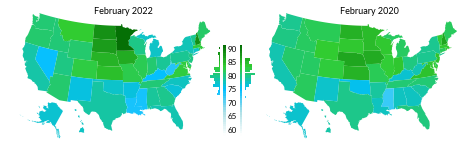

In [19]:
# Map settings
m = Basemap(llcrnrlon=-121, llcrnrlat=20, urcrnrlon=-64, urcrnrlat=49,
            projection='lcc', lat_1=33, lat_2=45, lon_0=-95)
m.readshapefile('shapefiles/states', 'states', drawbounds=False);

colors = ["white", "powderblue", "deepskyblue", "limegreen", "darkgreen"]
cmap = LinearSegmentedColormap.from_list("mycmap", colors)
norm = Normalize(vmin=vmin, vmax=vmax)

# Draw map
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(7.0, 2.4))
fig.tight_layout()

for group, axval in [(-1, 0), (-25, 1)]:
    plt.sca(axes[axval])
    axes[axval].axis('off')
    m.drawmapboundary()
    
    for info, shape in zip(m.states_info, m.states):
        
        fc = cmap(norm(data[info['STATE_ABBR']].iloc[group]))
        # Alaska and Hawaii moved
        if info['STATE_ABBR'] == 'HI':
            shape = [(x + 5200000, y - 1400000) for x,y in shape]
        elif info['STATE_ABBR'] == 'AK':
            shape = [(x*0.35 + 1100000, y*0.35 - 1300000) for x,y in shape]
        axes[axval].add_patch(Polygon(shape, fc=fc))
    
    date = dtxt(data.index[group])['mon1']
    plt.text(0.42, 0.97, date, fontsize=9, 
             transform=axes[axval].transAxes)
    
ax_inset = inset_axes(axes[0], width='-30%', height='70%', loc=4, borderpad=0.5)
for tick_label in [60, 65, 70, 75, 80, 85, 90]:
    plt.text(0.6, norm(tick_label), tick_label, fontsize=8, 
             ha='center', va='center', transform=ax_inset.transAxes)
ax_inset.axis('off')

# Draw custom legend
for group, pt, pt2 in [(-1, 0.71, 0.8), (-25, 0.44, 0.4)]:
    for i in np.linspace(58,92,40):
        rect = Rectangle(xy=(pt, norm(i)), width=0.04, height=1/35, 
                         fc=cmap(norm(i)), ec=None)
        ax_inset.add_patch(rect)    
    
    bins = pd.cut(data.iloc[group], np.linspace(58,92,33)).apply(lambda x: x.left)
    res = data.iloc[group].groupby(bins).count()
    for i, v in res.items():
        if group == -1:
            adj = (v / 50)
        else:
            adj = 0
        if v > 0:
            rect = Rectangle(xy=(pt2 + adj, norm(i)), width= -(v / 50), 
                             height=1/33, fc=cmap(norm(i)), ec=None)
            ax_inset.add_patch(rect)    
    
plt.savefig('../chartbook/data/pa_epop_map.pgf', bbox_inches='tight')

In [20]:
pr = -37 if data.index[-1] >= pd.to_datetime('2022-03-01') else -25
prtxt = 'three' if pr == -37 else 'two'
s = data.iloc[-1] - data.iloc[pr]
ltdt = dtxt(data.index[-1])['mon1']
prdt = dtxt(data.index[pr])['mon1']
groups = (s.agg(higher=lambda x: (x > 0).sum(),
                lower=lambda x: (x < 0).sum(),
                unchanged=lambda x: (x == 0).sum())
           .sort_values(ascending=False)
           .rename({'unchanged': 'the same'})) 
mainhl = groups.index[0]
v = groups.iloc[0]
mainn = numbers(f'{v:.1f}') if v < 10 else v
secondhl = ''
and1 = 'and ' if groups.iloc[2] == 0 else ''
if groups.iloc[1] > 0:
    v = groups.iloc[1]
    n = numbers[f'{v:.1f}'] if v < 10 else v
    secondhl = f', {and1}{groups.index[1]} in {n} states'
thirdhl = ''
if groups.iloc[2] > 0:
    v = groups.iloc[2]
    n = numbers[f'{v:.1f}'] if v < 10 else v
    thirdhl = f', and {groups.index[2]} in {n} states'
text = (f'The age 25--54 employment rate is {mainhl} in '+
        f'{ltdt} than it was in {prdt} in {mainn} states'+
        f'{secondhl}{thirdhl}. ')
sa = pd.read_csv(data_dir / 'state_pa_epop_sa_raw.csv', 
                   index_col='date', parse_dates=True)
s2 = sa.iloc[-3:].mean() - sa.iloc[-6:-3].mean()
grp = (s2.agg(increased=lambda x: (round(x, 1) > 0).sum(),
              decreased=lambda x: (round(x, 1) < 0).sum(),
              unchanged=lambda x: (round(x, 1) == 0).sum())
         .sort_values(ascending=False)
         .rename({'unchanged': 'was unchanged'})) 
mainhl = grp.index[0]
v = grp.iloc[0]
mainn = numbers(f'{v:.1f}') if v < 10 else v
secondhl = ''
and1 = 'and ' if grp.iloc[2] == 0 else ''
if grp.iloc[1] > 0:
    v = grp.iloc[1]
    n = numbers[f'{v:.1f}'] if v < 10 else v
    secondhl = f', {and1}{grp.index[1]} in {n} states'
thirdhl = ''
if grp.iloc[2] > 0:
    v = grp.iloc[2]
    n = numbers[f'{v:.1f}'] if v < 10 else v
    thirdhl = f', and {grp.index[2]} in {n} states'
txt1 = (f'{text}Comparing the latest three months to the '+
        'previous three months, the seasonally-adjusted age '+
        f'25--54 employment rate {mainhl} in {mainn} states'+
        f'{secondhl}{thirdhl}.')
write_txt(text_dir / 'state_pa_emp.txt', txt1)
print(txt1, '\n')

states = {i['STATE_ABBR']: i['STATE_NAME'] 
          for i in m.states_info}
top = data.iloc[-1].sort_values(ascending=False).iloc[:3]
topt = [f'{states[top.index[i]]} ({top.iloc[i]:.1f} percent)' 
        for i in [0, 1, 2]]
txt2 = (f'In {ltdt}, the states with the highest employment rates '+
        f'for 25 to 54 year olds are {topt[0]}, {topt[1]}, and '+
        f'{topt[2]}.')
write_txt(text_dir / 'state_pa_emp_t3.txt', txt2)
print(txt2)

The age 25--54 employment rate is lower in February 2022 than it was in February 2020 in 37 states, and higher in 14 states. Comparing the latest three months to the previous three months, the seasonally-adjusted age 25--54 employment rate increased in 28 states, decreased in 19 states, and was unchanged in four states. 

In February 2022, the states with the highest employment rates for 25 to 54 year olds are Minnesota (90.7 percent), New Hampshire (88.2 percent), and North Dakota (88.0 percent).
